# 17. cGAN  
----  
목차..는 없습니다.

In [1]:
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import time

from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [2]:
data_path = '/content/drive/MyDrive/colab/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


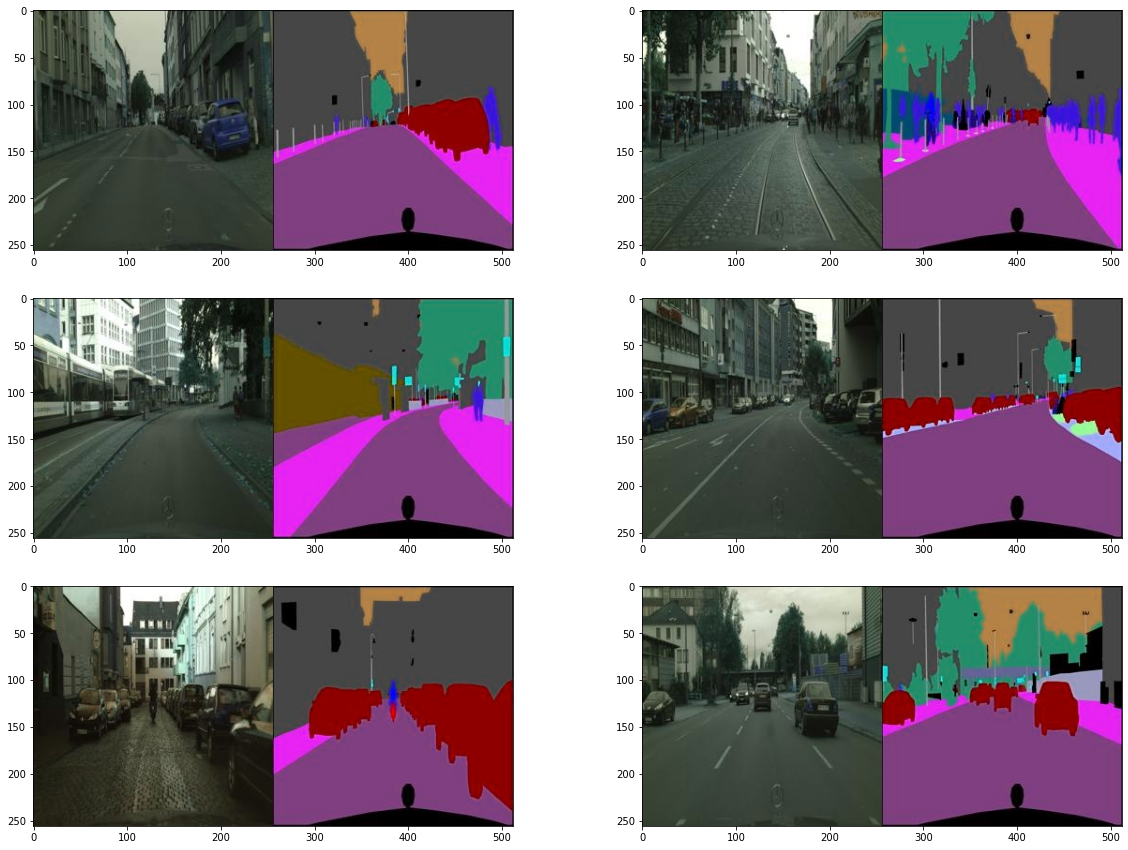

In [3]:
# 데이터 확인해보기
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(len(os.listdir(data_path)))]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# 데이터 shape 보기
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


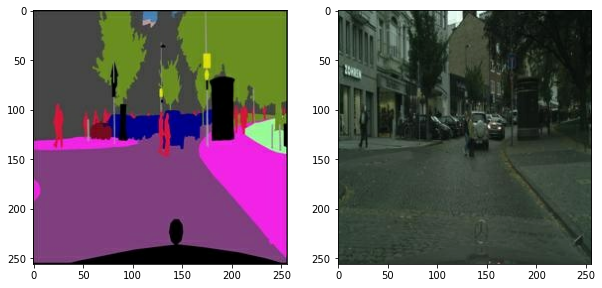

In [5]:
# nomaliztion 하는 함수
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

# denormaliztion 하는 함수
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# 이미지 불러오는 함수
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [6]:
# augmentation 적용
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    #여기 두개 함수의 의미를 모르겠..다..
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # random_crop() : 랜덤하게 함수를 잘라주는 함수.
    out = image.random_crop(padded, size=[256, 256, 6])
    
    # random_flip_left_right() : 랜덤하게 좌우 반전해주는 함수
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    # augmentation 후 다시 unifiorm을 만들어주나보다.
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

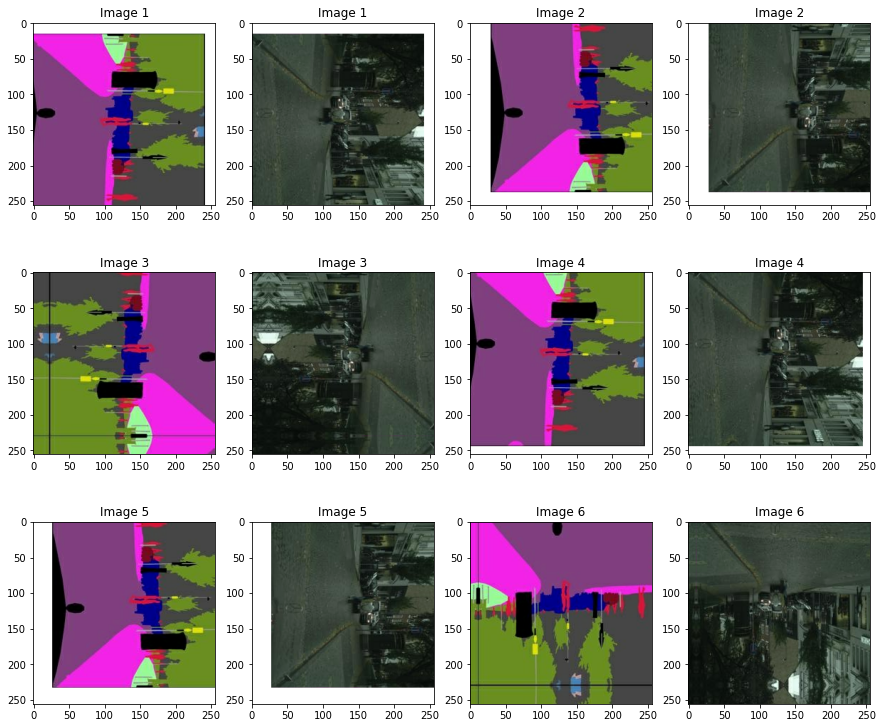

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

augmentation이 잘 되었는지 확인. 더 많은 augmentation을 해보는 게 좋았을듯하다.

IndexError: ignored

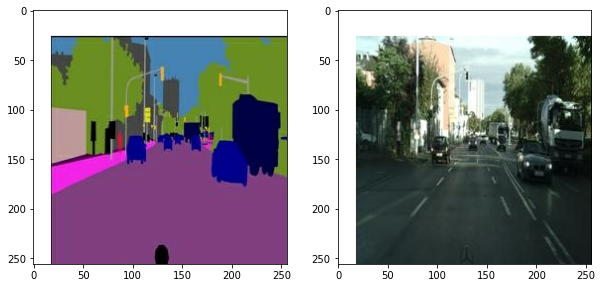

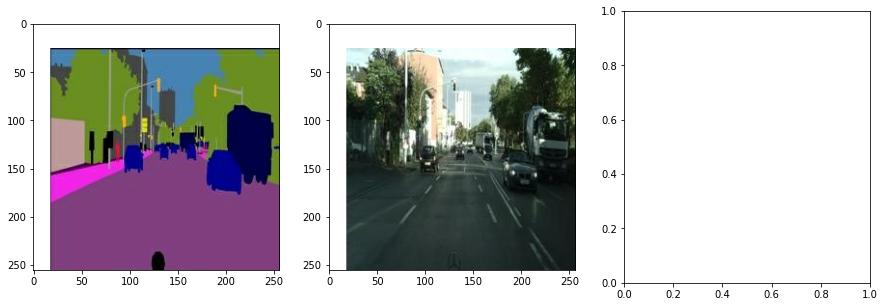

In [8]:
# train 데이터셋 만들기

# get_train함수는 load_img함수와 apply_augmentation 함수를 사용하는 함수
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

# data.Dataset.list_files() : 패턴과 일치하는 데이터셋을 만드는 함수
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)


sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,3,2); plt.imshow(colored[0].astype(np.uint8))
plt.subplot(1,3,3); plt.imshow(sample[0][2].astype(np.uint8))

 - sample[0][0]+1 을 하는 이유가 궁금해서 sample의 shape를 알아보려고 하던 와중 batch가 튜플로 만들어진다는 사실을 알게 됐다. 아래 과정을 쭉 따라가 보니 +1을 해서 *127.5를 하면 최대값이 255가 되는것으로 보였는데 실컷 다 하고 위로 올라가 함수를 보니 nomalize에서 (x/127.5)-1을 해줬던 걸 반대로 했던 거였다. 그래도 batch의 자료 구조를 알게 되어서 나름 만족스러운 경험이였음.  
 - sample[0]은 2개인 것으로 보아 sketch, colored이고 이것 또한 튜플형식의 자료구조.

In [9]:
print(len(sample))
print(len(sample[0]))
print(len(sample[0][0]))
print(sample[0][0].shape)
print((sample[0][0]+1)*127.5)

1
2
4
(4, 256, 256, 3)
[[[[255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   ...
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]]

  [[255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   ...
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]]

  [[255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   ...
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]]

  ...

  [[255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   ...
   [128.         62.999996  127.       ]
   [128.         62.999996  127.  

In [10]:
# layer들을 Block단위로 쌓기 위해서 만드는 듯.
# 4는 filter size, 2는 stride "same"은 padding인듯 함.
# 이때까지 노드를 하면서 쭉 궁금했던 건데 bias는 왜 False로 하는건지 궁금.
# BatchNormalization()은 0.9로 설정.
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization(momentum=0.9)
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [11]:
# EncodeBlock을 이용하여 Encoder만드는 class
# layer를 list로 만들어 사용. enumerate하는 이유는 첫 번째
# layer를 예외적으로 선언해주기 위해서 인듯.
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [12]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

In [13]:
# DecodeBlock인데 EncodeBlock과 다르게 활성함수를 ReLU로 사용.
# 건방진 것 같아서 LeakyReLU로 변경하겠습니다. (제발 무사히 돌아가길..)
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization(momentum=0.9)
        self.lrelu= layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.lrelu(x)

In [14]:
# Decoder를 만드는 class Encoder 만들때와 크게 다른 건 없고
# Conv2DTranspose layer가 있다는 차이가 있음.
# 여기선 딱히 수정하지 않겠음.
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

In [16]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [17]:
EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [18]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        # 여기서 call 할때  resblock을 만듦. skip connection 해줌.
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [19]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

In [20]:
# Discriminator에 들어갈 Block 만드는 class
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization(momentum=0.9) if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [21]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization(momentum=0.9)(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_45 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [22]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [23]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

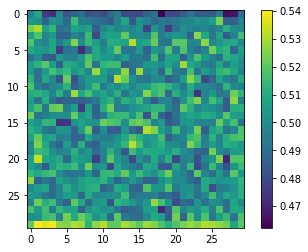

In [24]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [25]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [26]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [27]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [28]:
history = {'Generator_loss':[], 'L1_loss':[], 'Discriminator_loss':[], 'epoch':[]}
generator = UNetGenerator()
discriminator = Discriminator()
def train(EPOCHS):
    start = time.time()
    
    for epoch in range(1, EPOCHS+1):
        for i, (sketch, colored) in enumerate(train_images):
            g_loss, l1_loss, d_loss = train_step(sketch, colored)
            history['Generator_loss'].append(float(g_loss))
            history['L1_loss'].append(float(l1_loss))
            history['Discriminator_loss'].append(float(d_loss))
            history['epoch'].append(epoch)
                    
            # 10회 반복마다 손실을 출력합니다.
            if (i+1) % 50 == 0:
                print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                        \nGenerator_loss:{g_loss.numpy():.4f} \
                        \nL1_loss:{l1_loss.numpy():.4f} \
                        \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

In [29]:
%%time
EPOCHS = 10
train(EPOCHS)

EPOCH[1] - STEP[50]                         
Generator_loss:0.7853                         
L1_loss:0.2198                         
Discriminator_loss:1.1803

EPOCH[1] - STEP[100]                         
Generator_loss:1.2624                         
L1_loss:0.1884                         
Discriminator_loss:0.8735

EPOCH[1] - STEP[150]                         
Generator_loss:1.4135                         
L1_loss:0.1818                         
Discriminator_loss:0.7327

EPOCH[1] - STEP[200]                         
Generator_loss:1.5858                         
L1_loss:0.2068                         
Discriminator_loss:0.4294

EPOCH[1] - STEP[250]                         
Generator_loss:1.4694                         
L1_loss:0.1726                         
Discriminator_loss:0.7750

EPOCH[2] - STEP[50]                         
Generator_loss:1.4186                         
L1_loss:0.1799                         
Discriminator_loss:0.9354

EPOCH[2] - STEP[100]                      

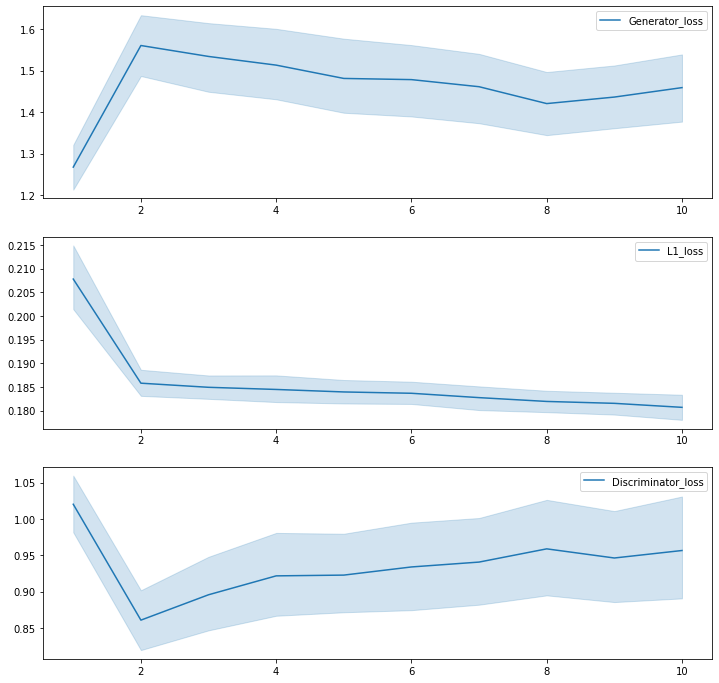

In [30]:
import seaborn as sns
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
sns.lineplot(x= history['epoch'], y= history['Generator_loss'] , label='Generator_loss')

plt.subplot(3, 1, 2)
sns.lineplot(x= history['epoch'], y=history['L1_loss'], label='L1_loss')

plt.subplot(3, 1, 3)
sns.lineplot(x= history['epoch'], y=history['Discriminator_loss'], label='Discriminator_loss')

In [31]:
def test_inds(num):
    test_ind = num

    f = data_path + os.listdir(data_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

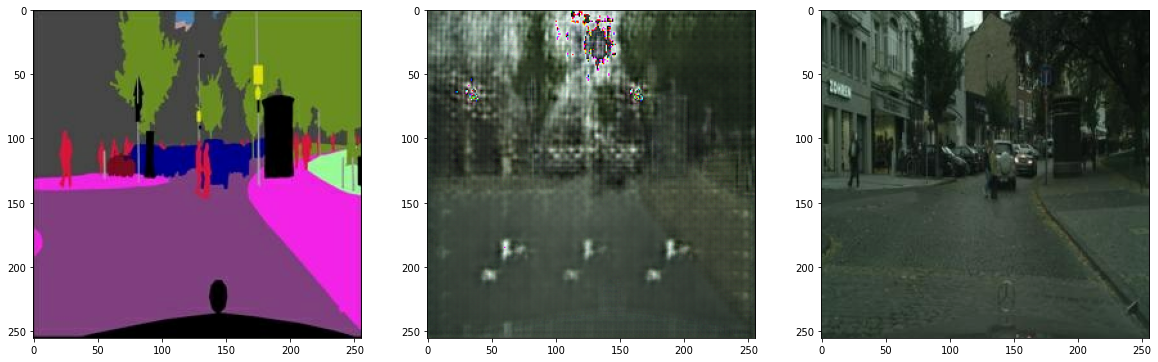

In [32]:
test_inds(1)

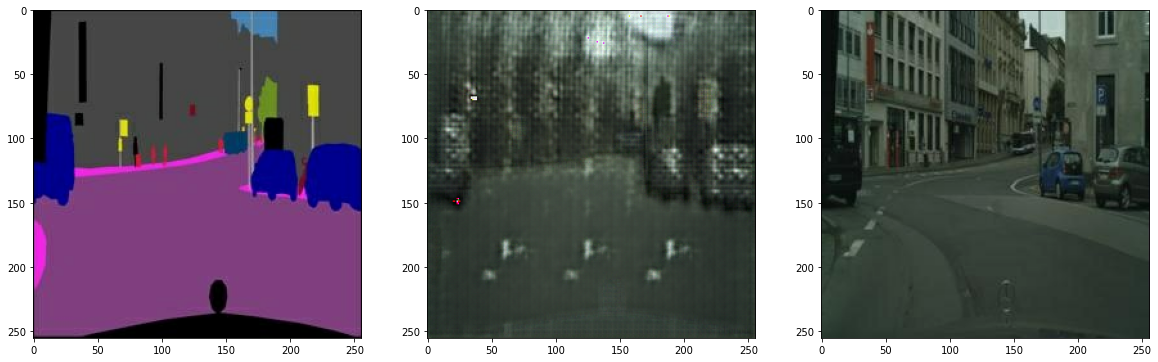

In [33]:
test_inds(2)

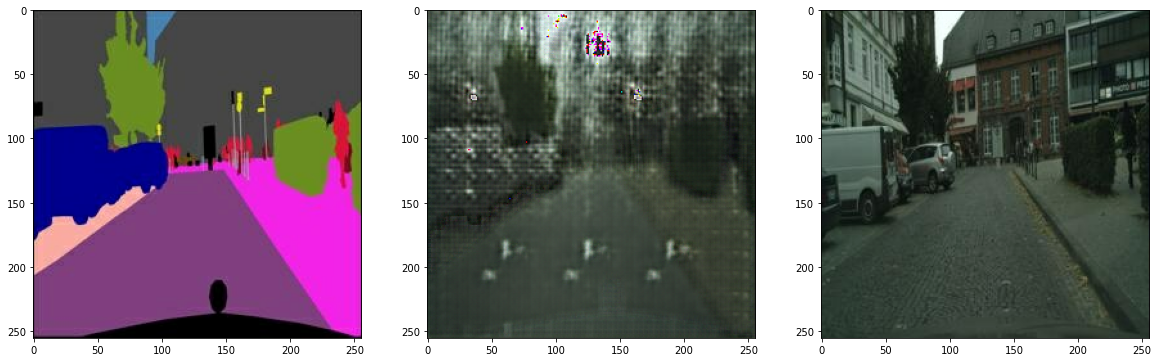

In [34]:
test_inds(3)

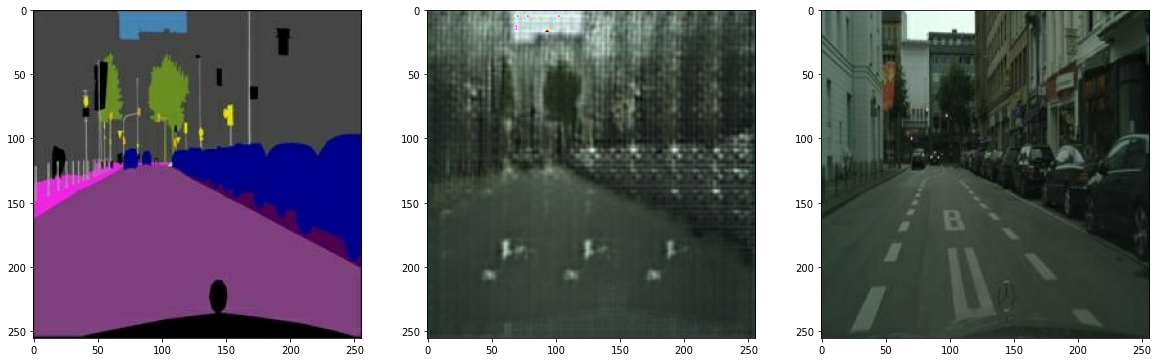

In [35]:
test_inds(4)

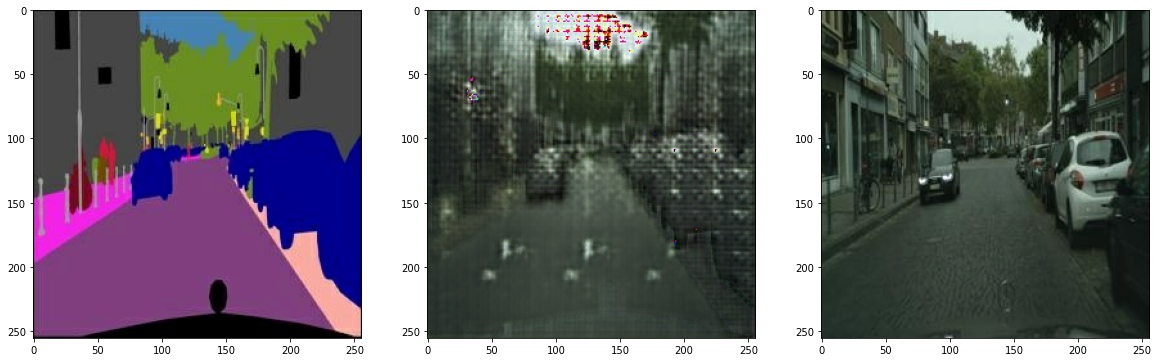

In [36]:
test_inds(5)

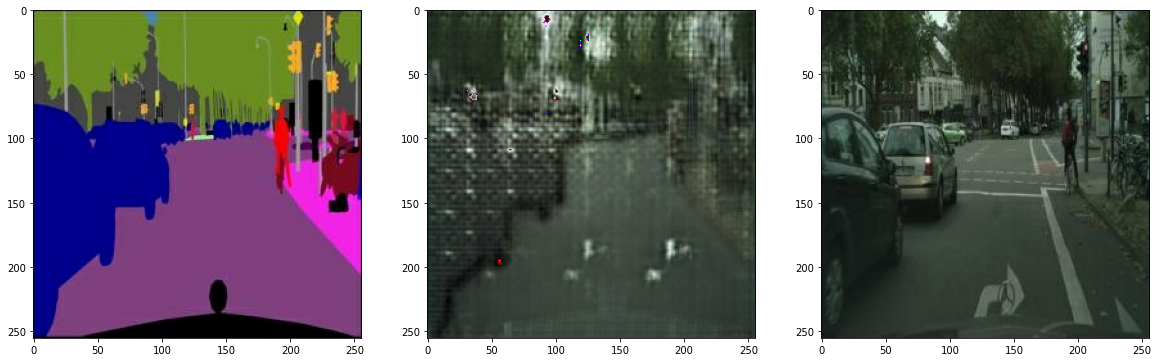

In [37]:
test_inds(6)

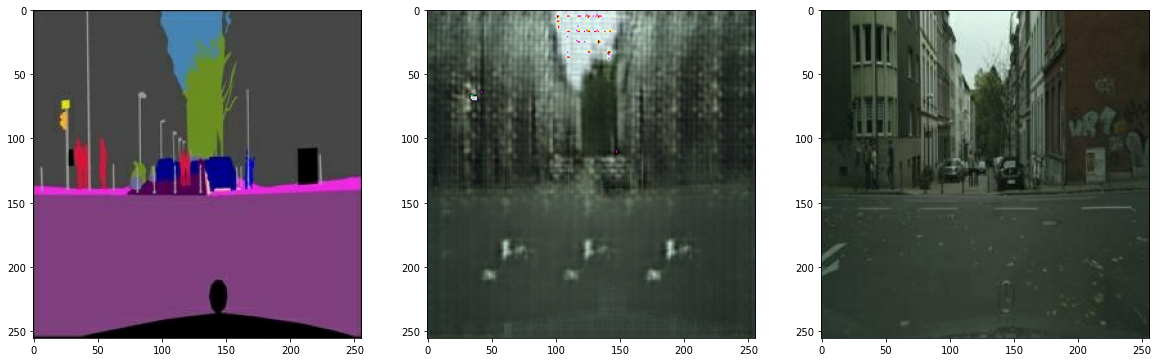

In [38]:
test_inds(7)

In [39]:
%%time
EPOCHS = 500
train(EPOCHS)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
L1_loss:0.1605                         
Discriminator_loss:0.7705

EPOCH[301] - STEP[100]                         
Generator_loss:1.1096                         
L1_loss:0.1486                         
Discriminator_loss:1.3242

EPOCH[301] - STEP[150]                         
Generator_loss:1.6751                         
L1_loss:0.1640                         
Discriminator_loss:1.5112

EPOCH[301] - STEP[200]                         
Generator_loss:0.8384                         
L1_loss:0.1535                         
Discriminator_loss:1.1039

EPOCH[301] - STEP[250]                         
Generator_loss:0.8222                         
L1_loss:0.1637                         
Discriminator_loss:0.9398

EPOCH[302] - STEP[50]                         
Generator_loss:1.4715                         
L1_loss:0.1703                         
Discriminator_loss:0.8391

EPOCH[302] - STEP[100]                         
Generator_loss:1.1628                   

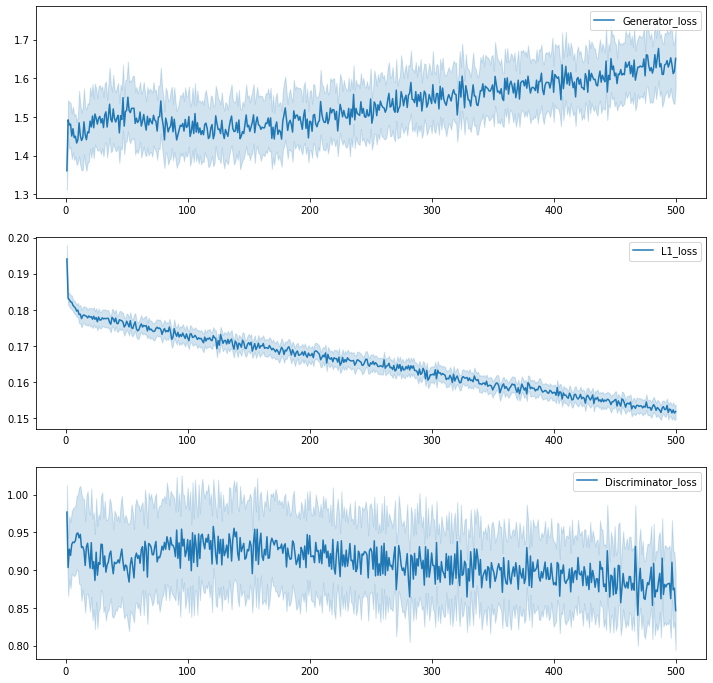

In [40]:
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
sns.lineplot(x= history['epoch'], y= history['Generator_loss'] , label='Generator_loss')

plt.subplot(3, 1, 2)
sns.lineplot(x= history['epoch'], y=history['L1_loss'], label='L1_loss')

plt.subplot(3, 1, 3)
sns.lineplot(x= history['epoch'], y=history['Discriminator_loss'], label='Discriminator_loss')

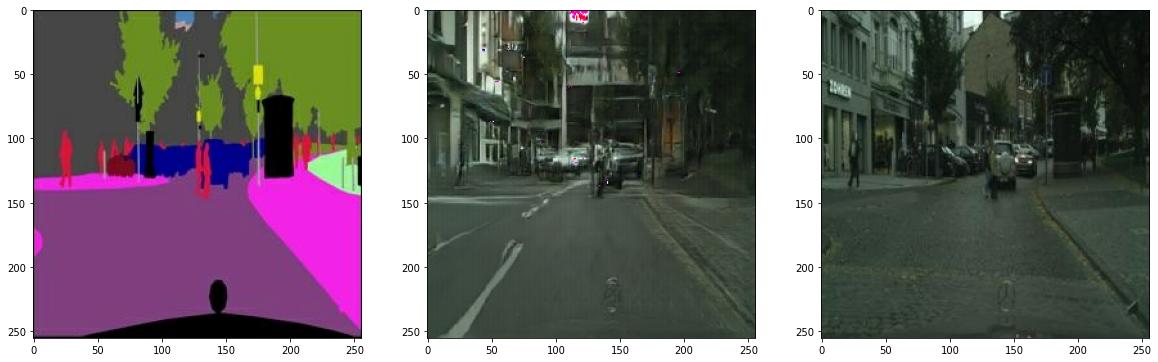

In [41]:
test_inds(1)

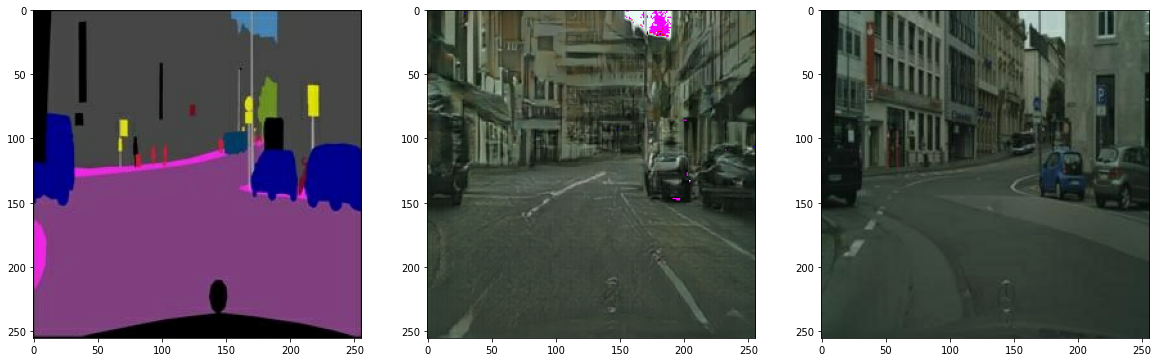

In [42]:
test_inds(2)

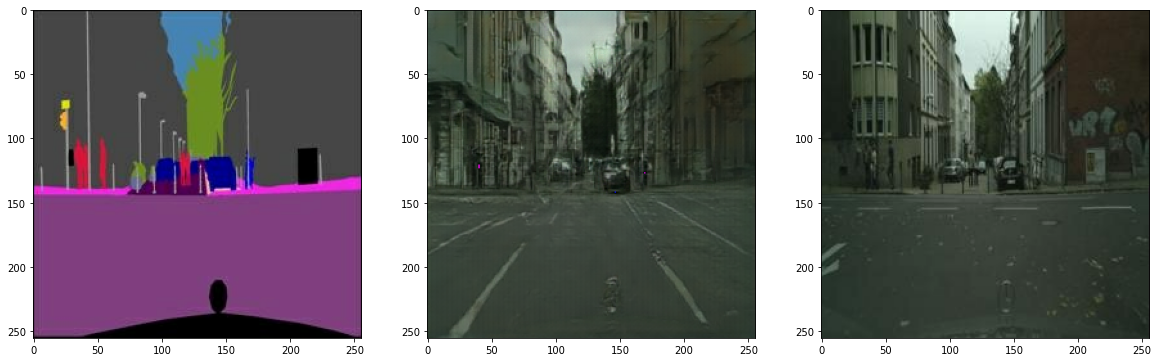

In [43]:
test_inds(7)

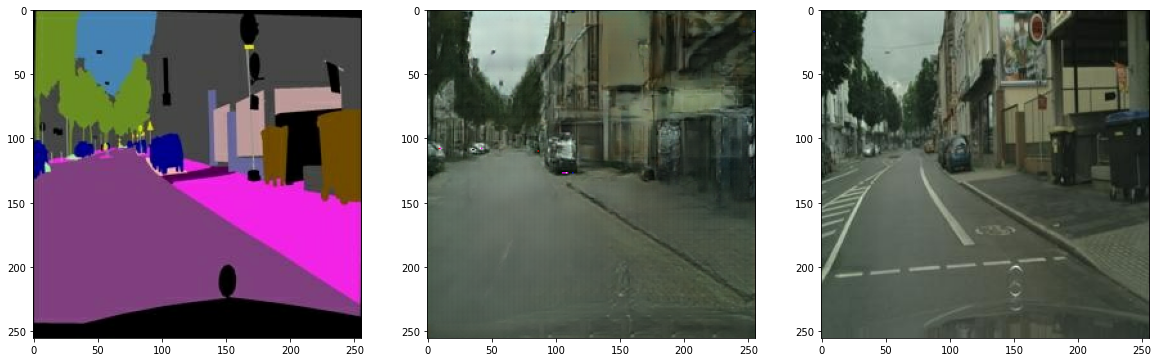

In [44]:
test_inds(150)

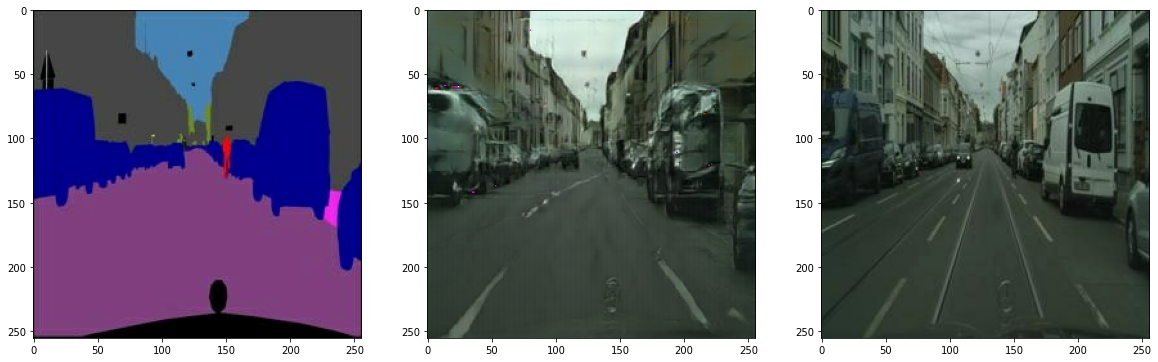

In [45]:
test_inds(450)

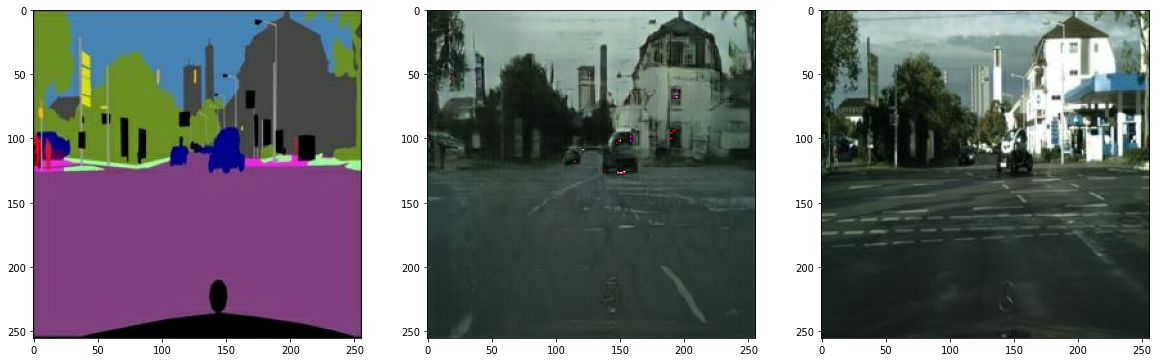

In [46]:
test_inds(687)

## 회고  
----  
 - 처음에 포켓몬이랑 위치가 다르게 설정 되어 있다는걸 모르고 진행하여 제대로 된 이미지에 스케치처럼 그렸다. 그래서 또 다시 시작하였으나, 러닝레이트를 너무 낮게 잡아서 에폭을 500회 이상 돌렸으나 회색화면만 그려내버렸다... 이번이 4회차 도전인데 성공적인 그림을 그릴 수 있게 되어 만족스럽다.  
 - 히스토리를 추가하여 그래프를 그려봤는데 resblock을 사용해서 그런지 500회 에폭을 진행하였음에도 Generaitor loss는 우상향하고 Discriminator loss는 우하향 중이였다. 오버피팅은 아직 일어나지 않았으며, 학습을 더 진행하면 그림이 더 나은 모습을 보여줄 수 있을 것이라는 뜻으로 해석했다.  
 - 전체적인 class 내 함수들의 기능에 대해 이해하려고 주석을 달아가며 읽어보았지만 제대로 이해한게 맞는지는 잘 모르겠다.  
 - gan 모델은 항상 재밌는 것 같다. (물론 진행 할때는 안재밌음.)